In [1]:
include("src/Sim.jl")

Main.Sim

In [2]:
using DifferentialEquations
using Plots
using .Sim

# DCモーター

### 時間変動する物理量

|物理量||単位|
|:-|:-:|:-|
| 印加電圧 | $v_M(t)$ |$V$|
| 電流| $i_M(t)$ | $A$ |
| 逆起電力 | $v_e(t)$ | $V$|
| 発生トルク | $\tau_M(t)$ | $Nm$ |
| 角速度 | $\omega(t)$ | rad/s |

### システムパラメータ
- 電気抵抗 $R$ [$\Omega$]

## DCMotorDiskの定義

In [3]:
@model DCMotorDisk begin
    ## モータ特性
    @parameter R     # 電機抵抗
    @parameter L     # インダクタンス
    @parameter K_e   # 逆起電力定数
    @parameter K_tau # トルク定数
    @parameter J_M   # 慣性モーメント
    
    ## ディスク特性
    @parameter J_I # 慣性モーメント
    @parameter D   # 粘性減衰係数
    
    ## 入力
    @parameter v_M # 印加電圧
    
    @blk In1 = InBlock() outport:v_M
    @blk Gain = GainBlock(1/L)
    @blk Integrator = IntegratorBlock() outport:i_M
    @blk Gain1 = GainBlock(K_tau) outport:tau_M
    @blk Gain2 = GainBlock(1/(J_M+J_I))
    @blk Integrator1 = IntegratorBlock() outport:omega
    @blk Gain3 = GainBlock(D)
    @blk Gain4 = GainBlock(K_e)
    @blk Gain5 = GainBlock(R)
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect v_M - Gain4 - Gain5 => Gain
    @connect Gain => Integrator
    @connect i_M => Gain1
    @connect i_M => Gain5
    @connect i_M => Out2
    @connect Gain1 - Gain3 => Gain2
    @connect Gain2 => Integrator1
    @connect omega => Out1
    @connect omega => Gain3
    @connect omega => Gain4
end

DCMotorDisk (generic function with 1 method)

## 単体テスト

In [4]:
@model TestDCMotorDisk begin
    @parameter R L K_e K_tau J_M J_I D v_M

    @blk Motor_and_Disk = DCMotorDisk(R=R, L=L, K_e=K_e, K_tau=K_tau, J_M=J_M, J_I=J_I, D=D, v_M=v_M) outport[1]:omega outport[2]:i_M
    @blk Step = StepBlock(steptime = 1, finalvalue = v_M) outport:v_M
    
    @connect Step => Motor_and_Disk
end

TestDCMotorDisk (generic function with 1 method)

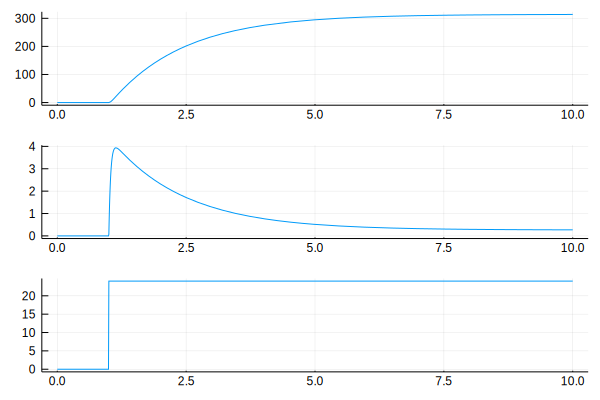

In [5]:
m = TestDCMotorDisk(R=5.7, L=0.2, K_e=7.16e-2, K_tau=7.2e-2, J_M=0.11e-3, J_I=1.3e-3, D=6.0e-5, v_M=24);
sol = @simulate(m, tspan=(0.0, 10.0), scope=(omega, i_M, v_M));
sol.graph

# タコジェネレータ

- 

## モデルの定義

In [6]:
@model Tachogenerator begin
    @parameter alpha_T # 変換係数
    
    @blk In1 = InBlock() outport:omega
    @blk Gain = GainBlock(60/(2*pi)) outport:N
    @blk Gain1 = GainBlock(alpha_T)
    @blk Out1 = OutBlock()
    
    @connect In1 => Gain
    @connect Gain => Gain1
    @connect Gain1 => Out1
end

Tachogenerator (generic function with 1 method)

## 単体テスト

In [7]:
@model TestTachogenerator begin
    @parameter alpha_T omega_d
    @blk tacho = Tachogenerator(alpha_T=alpha_T) outport:v_T
    @blk Ramp = RampBlock(starttime = 10, slope = omega_d) outport:omega
    
    @connect Ramp => tacho
end

TestTachogenerator (generic function with 1 method)

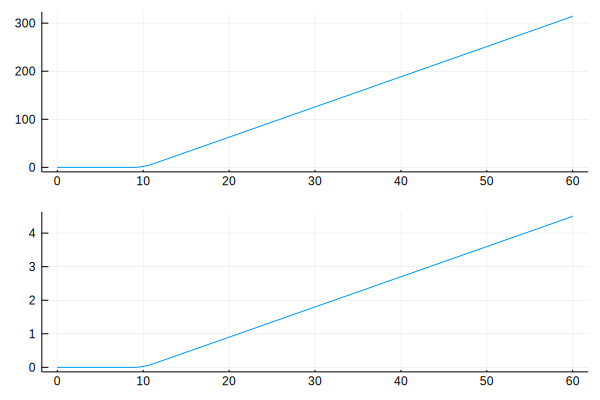

In [8]:
m = TestTachogenerator(alpha_T=1.5/1000, omega_d=2*pi);
sol = @simulate(m, tspan=(0.0, 60.0), scope=(omega, v_T));
sol.graph